In [1]:
!pip install pims av
!python --version

     |████████████████████████████████| 92kB 5.9MB/s 
     |████████████████████████████████| 37.2MB 79kB/s 
  Created wheel for pims: filename=PIMS-0.5-cp37-none-any.whl size=84328 sha256=0873046168f93d2b5f308b506583ffc6ef1b9eb8bd1fff687e01ad60a1bc3db6
  Stored in directory: /root/.cache/pip/wheels/0e/0a/14/4c33a4cc1b9158e57329a38e8e3e03901ed24060eb322d5462
Successfully built pims
Python 3.7.10


In [2]:
import numpy as np
import cv2
import pims
from tqdm.notebook import trange

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3686400/45929032 bytes (8.0%)7921664/45929032 bytes (17.2%)11886592/45929032 bytes (25.9%)14368768/45929032 bytes (31.3%)18169856/45929032 bytes (39.6%)22257664/45929032 bytes (48.5%)26206208/45929032 bytes (57.1%)30326784/45929032 bytes (66.0%)34136064/45929032 bytes (74.3%)38207488/45929032 bytes (83.2%)41672704/45929032 bytes (90.7%)45465600/45929032 bytes (99.0%)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#resolution and labels

# TESLA resolution
#W = 1280
#H = 960

# COMMA.AI resolution
#W = 1164
#H = 874

# low resolutions (to avoid low memory problems)
#W = 480
#H = 320
W = 320
H = 160

LABEL_DICT = {0: "no crossroad", 1: "crossroad"}  # NOTE: no need to change this for 2 classes (argmax still gets us the same results)

In [5]:
from os import listdir

# Get data from files
def get_data(video_path, log_path):
  # NOTE: it turns out that .txt files work for 2 class classification as well

  # for txt file (binary classification)
  with open(log_path, "r") as log_file:
    labels = log_file.read().split("\n")[:-1]
    log_file.close()

  print("Log file read")

  # make a Video Object instead of loading all frames in memory
  # to access frames just do: frame = frames[n]
  print("Extracting frames ...")
  frames = pims.Video(video_path, format="mp4")
  print("Done extracting frames")

  return frames, np.array(labels).astype(np.float)

video_path = "/content/drive/MyDrive/OpenCRD_dataset/city_1.mp4"  # CHANGE THIS
log_path = video_path[:-3] + "txt"
#log_path = video_path[:-3] + "log"

frames, labels = get_data(video_path, log_path)
print(labels)

# get all files to train model on all of them at once
base_dir = "/content/drive/MyDrive/OpenCRD_dataset/"
video_files = []
log_files = []
for f in listdir(base_dir):
  if f.endswith(".mp4"):
    video_files.append(f)
  elif f.endswith(".txt"):
    log_files.append(f)
video_files, log_files = sorted(video_files), sorted(log_files)
print(video_files)
print(log_files)

assert len(video_files) == len(log_files)

Log file read
Extracting frames ...
Done extracting frames
[0. 0. 0. ... 0. 0. 0.]
['city_1.mp4', 'city_2.mp4', 'city_3.mp4', 'city_4.mp4', 'city_highway.mp4', 'highway_town_mix.mp4']
['city_1.txt', 'city_2.txt', 'city_3.txt', 'city_4.txt', 'city_highway.txt', 'highway_town_mix.txt']


crossroad


/usr/local/lib/python3.7/dist-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


(160, 320, 3)


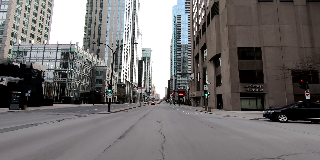

In [ ]:
from google.colab.patches import cv2_imshow

idx = 800
print(LABEL_DICT[labels[idx]])
frame = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
print(frame.shape)
cv2_imshow(frame)

In [6]:
# make pims video into actual numpy frames
def conv_frames(frames):
  imgs = []
  print("Getting frames into proper arrays")
  for frame in frames:
    imgs.append(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (W,H)))
  print("Frames converted to numpy arrays")
  return np.array(imgs)

#imgs = conv_frames(frames)
#cv2_imshow(imgs[800])

In [ ]:
# check for undersampling of crossroads (for binary classification .txt log_file)
# prints the percentage of crossroads in the dataset
np.count_nonzero(labels == 1) / len(labels)

0.43634642688121156

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.conv2_bn1 = nn.BatchNorm2d(16)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv2_bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv2_bn3 = nn.BatchNorm2d(64)

    # Fully connected layers
    self.fc1 = nn.Linear(64 * 16 * 36, 120)     # for 320x160 image 64 channels
    self.bn1 = nn.BatchNorm1d(num_features=120)
    self.fc2 = nn.Linear(120, 84)
    self.bn2 = nn.BatchNorm1d(num_features=84)
    self.fc3 = nn.Linear(84, 1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv2_bn1(self.conv1(x))))
    x = self.pool(F.relu(self.conv2_bn2(self.conv2(x))))
    x = self.pool(F.relu(self.conv2_bn3(self.conv3(x))))
    #print(x.shape)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x = torch.sigmoid(self.fc3(x))
    return x
  
  def num_flat_features(self, x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features


In [8]:
# ResNet block
class ResBlock(nn.Module):
  def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
    super(ResBlock, self).__init__()

    self.num_layers = num_layers
    if self.num_layers > 34:
      self.expansion = 4
    else:
      self.expansion =1

    # ResNet50, 101 and 152 include additional layer of 1x1 kernels
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    if self.num_layers > 34:
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    else:
      # for ResNet18 and 34, connect input directly to 3x3 kernel (skip first 1x1)
      self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.elu = nn.ELU()
    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x
    if self.num_layers > 34:
      x = self.elu(self.bn1(self.conv1(x)))
    x = self.elu(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))
    
    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
    x += identity
    x = self.elu(x)
    return x

# ResNet model
class ResCRDetector(nn.Module):
  def __init__(self, num_layers, block, image_channels):
    assert num_layers in [18, 34, 50, 101, 152], "Unknown ResNet architecture, number of layers must be 18, 34, 50, 101 or 152"
    super(ResCRDetector, self).__init__()

    # for output layer (polylines shape)
    self.n_coords = 2  # 2 coordinates: x,y
    self.n_points = 4  # number of points of each polyline
    self.max_n_lines = 6 # max number of polylines per frame

    if num_layers < 50:
      self.expansion = 1
    else:
      self.expansion = 4
    if num_layers == 18:
      layers = [2, 2, 2, 2]
    elif num_layers == 34 or num_layers == 50:
      layers = [3, 4, 23, 3]
    elif num_layers == 101:
      layers = [3, 8, 23, 3]
    else:
      layers = [3, 8, 36, 3]

    self.in_channels = 16
    self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=7, stride=2, padding=3)  # TODO: maybe kernel 5x5
    self.bn1 = nn.BatchNorm2d(16)
    self.elu = nn.ELU()
    self.avgpool1 = nn.AvgPool2d(3, 2, padding=1)

    # ResNet Layers
    self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=32, stride=1)
    self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=64, stride=2)
    self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=128, stride=2)
    self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=256, stride=2)

    self.avgpool2 = nn.AvgPool2d(1, 1)

    # Fully Connected Layers
    self.fc1 = nn.Linear(256*5*10, 1024) # NOTE: this works only with ResNet18
    self.fc_bn1 = nn.BatchNorm1d(1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc_bn2 = nn.BatchNorm1d(128)
    self.fc3 = nn.Linear(128, 84)
    self.fc_bn3 = nn.BatchNorm1d(84)
    self.fc4 = nn.Linear(84, 1)

  def forward(self, x):
    x = self.avgpool1(self.elu(self.bn1(self.conv1(x))))
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool2(x)
    #print(x.shape)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc_bn1(self.fc1(x)))
    x = F.relu(self.fc_bn2(self.fc2(x)))
    x = F.relu(self.fc_bn3(self.fc3(x)))
    x = torch.sigmoid(self.fc4(x))
    return x

  def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
    layers = []
    identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                        nn.BatchNorm2d(intermediate_channels*self.expansion))
    layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
    self.in_channels = intermediate_channels*self.expansion
    for i in range(num_residual_blocks - 1):
      layers.append(block(num_layers, self.in_channels, intermediate_channels))
    return nn.Sequential(*layers)

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

[~] Cleared cuda cache


[~] Loading from files: /content/drive/MyDrive/OpenCRD_dataset/city_1.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_1.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
[~] Loading from files: /content/drive/MyDrive/OpenCRD_dataset/city_2.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_2.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
[~] Loading from files: /content/drive/MyDrive/OpenCRD_dataset/city_3.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_3.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
[~] Loading from files: /content/drive/MyDrive/OpenCRD_dataset/city_4.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_4.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy


[+] Epoch 1



[+] Epoch 2



[+] Epoch 3



[+] Epoch 4



[+] Epoch 5



[+] Epoch 6



[+] Epoch 7



[+] Epoch 8



[+] Epoch 9



[+] Epoch 10



[+] Trained model on all data files


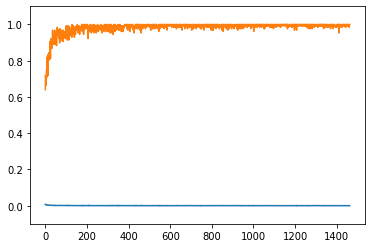

In [9]:
# train the network
def train(frames, labels, model):
  loss_function = nn.BCELoss()  # for binary classification
  optim = torch.optim.Adam(model.parameters(), lr=0.001) 

  losses, accuracies = [], []
  epochs = 11
  BS = 128
  
  # for rounding up to a threshold instead of 0.5 (works with torch.where)
  x = torch.ones(128, 1).to(device)
  y = torch.zeros(128, 1).to(device)

  for epoch in range(epochs):
    print("[+] Epoch", epoch)
    t = trange(0, len(frames) - BS, BS)  # trange progress bar
    visited_idx = np.array([])

    for i in t:
      # get data into network
      rng = np.random.default_rng()
      samp = rng.choice(len(frames), size=BS, replace=False)
      #visited_idx = np.concatenate((visited_idx, samp)) # add the new random values to visited indices

      # TODO: we must not sample the same frames in the same epoch (use visited_idx)
      X_train = []
      Y_train = []
      for j in samp:
        frame = frames[j]
        frame = np.moveaxis(frame, -1, 0) # [batch_size, channels, height, width]
        X_train.append(frame)
        Y_train.append([labels[j]])
      samp = []
      X = torch.tensor(np.array(X_train)).float().to(device)
      Y = torch.tensor(np.array(Y_train)).float().to(device)

      # forward feed and backpropagation
      optim.zero_grad()
      out = model(X)
      #cat = torch.round(out)
      cat = torch.where(out >= 0.8, x, y) # round up to a threshold instead of 0.5
      accuracy = (cat == Y).float().mean()
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optim.step()

      # print stats
      loss = loss.item()
      accuracy = accuracy.item()
      losses.append(loss/100) # /100 so that we can see it in the graph
      accuracies.append(accuracy)
      t.set_description("loss %.2f accuracy %.2f out %.2f" % (loss, accuracy, out.mean().item()))

  # plot losses and accuracies
  plt.ylim(-0.1, 1.1)
  plot(losses)
  plot(accuracies)

  return model

if device.type == "cuda":
  torch.cuda.empty_cache()  # to avoid running out of cuda memory
  print("[~] Cleared cuda cache")

# train for all files
#model = ConvNet().to(device).train() # Uncomment this if you want to train from the start, else just run the loader block first
model = ResCRDetector(18, ResBlock, image_channels=3).to(device).train()

# TODO: check for oversampling (more 0s than 1s)
# get all frames and labels and stich them in the same array, then train the network on the whole dataset
for i in trange(len(video_files)):
  print("[~] Loading from files: %s , %s" % (base_dir+video_files[i], base_dir+log_files[i]))
  frames, labels = get_data(base_dir+video_files[i], base_dir+log_files[i])
  frames = conv_frames(frames)
  if i == 0:
    all_frames = frames
    all_labels = labels
  else:
    all_frames = np.concatenate((all_frames, frames), axis=0)
    all_labels = np.concatenate((all_labels, labels), axis=0)

frames, labels = [], [] # free up memory
print("[+] Training model ...")
model = train(all_frames, all_labels, model)
print("[+] Trained model on all data files")

Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
(10798, 160, 320, 3)
(10798,)


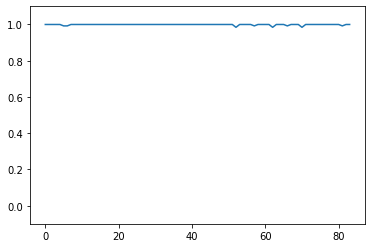

In [ ]:
# evaluate model
def evaluate(model, X_test, Y_test):
  # for rounding up to a threshold instead of 0.5 (works with torch.where)
  x = torch.ones(128, 1).to(device)
  y = torch.zeros(128, 1).to(device)

  BS = 128
  accuracies = []

  for i in trange(0, len(frames) - BS, BS):
    X_test = []
    Y_test = []
    for j in range(BS):
      frame = frames[i+j]
      frame = np.moveaxis(frame, -1, 0) # [batch_size, channels, height, width]
      X_test.append(frame)
      Y_test.append([labels[i+j]])
    X = torch.tensor(np.array(X_test)).float().to(device)
    Y = torch.tensor(np.array(Y_test)).float().to(device)

    out = model.forward(X)
    cat = torch.where(out >= 0.8, x, y) # round up to a threshold instead of 0.5
    accuracy = (cat == Y).float().mean()
    accuracy = accuracy.item()
    accuracies.append(accuracy)
  
  # plot losses and accuracies
  plt.ylim(-0.1, 1.1)
  plot(accuracies)

eval_video_path = "/content/drive/MyDrive/OpenCRD_dataset/city_1.mp4"  # CHANGE THIS

model.eval()
frames, labels = get_data(base_dir+video_files[i], base_dir+log_files[i])
frames = conv_frames(frames)
print(frames.shape)
print(labels.shape)
evaluate(model, frames, labels)


In [10]:
# save model for later retraining
#model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/cr_detector.pth"
model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/resnet_cr_detector.pth"
torch.save(model.state_dict(), model_path)
print("Model saved to path", model_path)

Model saved to path /content/drive/MyDrive/OpenCRD_dataset/models/resnet_cr_detector.pth


In [13]:
# load the model
#model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/cr_detector.pth"
model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/resnet_cr_detector.pth"
#model = ConvNet()
model = ResCRDetector(18, ResBlock, image_channels=3)
model.load_state_dict(torch.load(model_path))
model.train()  # for training on new dataset
#model.eval()  # for evaluation
model.to(device)

ResCRDetector(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (avgpool1): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0)
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, trac

/usr/local/lib/python3.7/dist-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


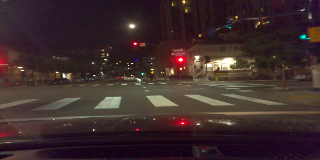

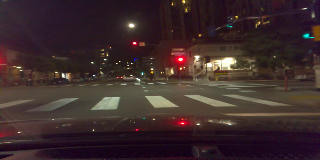

Frame: 1000
[+] 1 -> crossroad
Frame: 1001
[+] 1 -> crossroad
tensor([[0.9986],
        [0.9993]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [14]:
from google.colab.patches import cv2_imshow

eval_path = "/content/drive/MyDrive/OpenCRD_dataset/city_4.mp4"
log_path = eval_path[:-4] + ".txt"

with open(log_path, "r") as log_file:
  eval_labels = log_file.read().split("\n")[:-1]
  log_file.close()

frames = pims.Video(eval_path, format="mp4")
idx = 1000

frame1 = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
frame2 = cv2.resize(cv2.cvtColor(frames[idx+1], cv2.COLOR_BGR2RGB), (W,H))
cv2_imshow(frame1)
cv2_imshow(frame2)
print("Frame:", idx)
print("[+]", eval_labels[idx], "->", LABEL_DICT[int(eval_labels[idx])])
print("Frame:", idx+1)
print("[+]", eval_labels[idx+1], "->", LABEL_DICT[int(eval_labels[idx+1])])
    
# forward to model
# NOTE: since we are using batch normalization, we need more than 1 images
X_test1 = np.moveaxis(frame1, -1, 0)
X_test2 = np.moveaxis(frame2, -1, 0)
X_test = []
X_test.append(X_test1)
X_test.append(X_test2)
X_test = np.array(X_test)
X = torch.tensor(X_test).float().to(device)

model.eval()
Y_pred = model(X)
print(Y_pred)